In [1]:
# 기본 라이브러리
import os # 운영체제와 상호 작용하기 위한 인터페이스 제공 (경로 생성, 파일 처리 등) 
from tqdm import tqdm # 반복문의 진행 상황을 시각적으로 표시하는 진행바  
#from sklearn.metrics import accuracy_score # 모델의 예측 정확도를 계산하기 위한 함수

# 이미지 처리와 시각화
import numpy as np # 대규모 다차원 배열 및 행렬 연산을 위한 라이브러리
import matplotlib.pyplot as plt # 데이터 시각화 및 플로팅을 위한 라이브러리
from PIL import Image, ImageDraw, ImageFont # 이미지 처리를 위한 라이브러리, 그리고 이미지에 그리기, 텍스트 기능 추가 

# PaddleOCR 관련 모듈
from PaddleOCR.tools.infer.predict_det import TextDetector # 텍스트 탐지를 위한 클래스 
from PaddleOCR.tools.infer.predict_rec import TextRecognizer # 텍스트 탐지를 위한 클래스
import PaddleOCR.tools.infer.utility as utility # PaddleOCR 추론 유틸리티

grep: warning: GREP_OPTIONS is deprecated; please use an alias or script


In [2]:
# 바운딩 박스의 색상 및 스타일 정보를 설정합니다.
box_color_RGBA  = (0,255,0,255) # 초록색 테두리
fill_color_RGBA = (0,255,0,50)  # 약간의 투명도를 가진 초록색 채우기

In [3]:
# 주어진 arguments를 파싱하여 TextDetector 객체를 생성합니다.
args = utility.parse_args()
text_detector = TextDetector(args) # Detection 모델을 불러옵니다 
text_recognizer = TextRecognizer(args) # Recognition 모델을 불러옵니다

grep: warning: GREP_OPTIONS is deprecated; please use an alias or script
grep: warning: GREP_OPTIONS is deprecated; please use an alias or script


In [4]:
### 이미지를 입력받아 Detection 부터 Recognition을 한번에 수행하는 모델을 만들어줍니다.  
class custom_ocr_model: 
    def __init__ (self, text_detector, text_recognizer): 
        """
        텍스트 검출 및 인식을 결합한 사용자 정의 OCR 모델 생성자.

        파라미터:
        - text_detector: 이미지에서 텍스트 영역을 검출하기 위한 모델
        - text_recognizer: 검출된 영역에서 텍스트를 인식하기 위한 모델
        """
        self.text_detector = text_detector 
        self.text_recognizer = text_recognizer 
        
    def predict(self, x):   
        """
        입력 이미지에 대해 텍스트 검출 및 인식을 수행합니다.

        파라미터:
        - x: 입력 이미지.

        반환값:
        - text: 이미지에서 인식된 텍스트.
        """ 
        # 입력을 numpy 배열로 변환
        x = np.array(x) 
        
        # 텍스트 영역 검출
        dt_boxes, _ = text_detector(x) 
        if len(dt_boxes) != 0:
            # 각 검출된 영역의 높이(세로 길이)를 계산합니다.
            heights = dt_boxes[:, 2, 1] - dt_boxes[:, 0, 1]  
            # 가장 크게 검출된 박스의 인덱스를 찾아서 해당 박스만 선택합니다.
            max_height_index = np.argmax(heights)
            dt_boxes = dt_boxes[max_height_index] 

            # 선택된 영역(폴리곤)을 포함하는 최소 직사각형의 좌측 상단 및 우측 하단 좌표를 계산합니다.
            left_up_x = max(0,int(min(dt_boxes[:,0]) - 10)) # 숫자가 잘리는 부분이 발생하여, 10 만큼의 패딩을 추가함
            left_up_y = max(0,int(min(dt_boxes[:,1]) - 10)) 
            right_down_x = int(max(dt_boxes[:,0]) + 10)  
            right_down_y = int(max(dt_boxes[:,1]) + 10) 
            
            # 해당 직사각형 영역을 이미지에서 잘라냅니다. 이 영역에서 텍스트 인식이 수행될 것입니다.
            x = x[left_up_y:right_down_y,left_up_x:right_down_x]
        else:  
            # 검출된 텍스트 영역이 없으면, 그 사실을 사용자에게 알립니다.
            print("검출된 텍스트 영역이 없습니다.")    
            return '검출된 텍스트 없음'
            
        # 잘라낸 영역에서 텍스트를 인식하고, 그 결과를 반환합니다.
        text,proba = text_recognizer([x])[0][0]     
        return text 
    
    def predict_visualization(self, x):   
        """
        입력 이미지에 대해 텍스트 검출 및 인식을 수행합니다.

        파라미터:
        - x: 입력 이미지.

        반환값:
        - text: 이미지에서 인식된 텍스트.
        """   
        img = x.copy()
        draw = ImageDraw.Draw(img, 'RGBA')
        # 입력을 numpy 배열로 변환
        x = np.array(x) 
        
        # 텍스트 영역 검출
        dt_boxes, _ = text_detector(x) 
        if len(dt_boxes) != 0:
            # 각 검출된 영역의 높이(세로 길이)를 계산합니다.
            heights = dt_boxes[:, 2, 1] - dt_boxes[:, 0, 1]  
            # 가장 크게 검출된 박스의 인덱스를 찾아서 해당 박스만 선택합니다.
            max_height_index = np.argmax(heights)
            dt_boxes = dt_boxes[max_height_index] 

            # 선택된 영역(폴리곤)을 포함하는 최소 직사각형의 좌측 상단 및 우측 하단 좌표를 계산합니다.
            left_up_x = max(0,int(min(dt_boxes[:,0]) - 10)) # 숫자가 잘리는 부분이 발생하여, 10 만큼의 패딩을 추가함
            left_up_y = max(0,int(min(dt_boxes[:,1]) - 10)) 
            right_down_x = int(max(dt_boxes[:,0]) + 10)  
            right_down_y = int(max(dt_boxes[:,1]) + 10) 
            
            # 해당 직사각형 영역을 이미지에서 잘라냅니다. 이 영역에서 텍스트 인식이 수행될 것입니다.
            x = x[left_up_y:right_down_y,left_up_x:right_down_x] 
            draw.rectangle((left_up_x, left_up_y, right_down_x, right_down_y), outline=box_color_RGBA, fill=fill_color_RGBA, width = 6)
            text,proba = text_recognizer([x])[0][0]     # 텍스트 인식 
            text_position = (left_up_x -150, left_up_y - 150)  # 박스의 위쪽에 텍스트를 표시하기 위해 y 좌표를 조정
            draw.text(text_position, f'Recognized Text: {text}', fill=box_color_RGBA, font = ImageFont.truetype('latin.ttf', 100)) # fill은 텍스트의 색상
            img = img.resize((500, 600))
            img.show()
            display(img)
            return text
        else:  
            # 검출된 텍스트 영역이 없으면, 그 사실을 사용자에게 알립니다.
            print("검출된 텍스트 영역이 없습니다.")    
            #return '검출된 텍스트 없음'

In [5]:
cus_model = custom_ocr_model(text_detector, text_recognizer)

display-im6.q16: unable to open X server `' @ error/display.c/DisplayImageCommand/432.


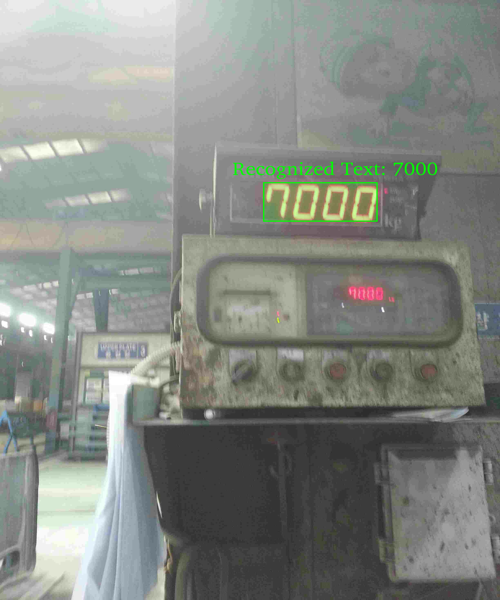

STR 추론 결과 7000


In [6]:
image_file_path = 'demo/examples/detection/image_data/03850.jpg'
img = Image.open(image_file_path)
pred = cus_model.predict_visualization(img) 
print('STR 추론 결과', pred)